# 10 Step Phase Shifting Technique

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from functions import mask_circ_img, load_raw_img, rad_to_deg

Print the polariser and analyser angles $\alpha$ and $\beta$ in degrees.

In [51]:
alphas = rad_to_deg(np.array([
    np.pi / 2, 
    5*np.pi/8, 
    3*np.pi/4, 
    7*np.pi/8, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2, 
    np.pi/2
]))

betas = rad_to_deg(np.array([
    0,
    np.pi/8,
    np.pi/4,
    3*np.pi/8,
    np.pi/2,
    0,
    0,
    np.pi/4,
    0,
    np.pi/2
]))

for i in range(len(alphas)):
    print(f'Alpha: {alphas[i]}, Beta: {betas[i]}')

Alpha: 90.0, Beta: 0.0
Alpha: 112.5, Beta: 22.5
Alpha: 135.0, Beta: 45.0
Alpha: 157.5, Beta: 67.5
Alpha: 90.0, Beta: 90.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 45.0
Alpha: 90.0, Beta: 0.0
Alpha: 90.0, Beta: 90.0


### Load the 10 images

In [60]:
base_path = "ten-step-images/"
file_type = ".CR2"

file_names = os.listdir(base_path)

imgs = []

for file_name in file_names:
    imgs.append(load_raw_img(base_path + file_name)[:,:,1] / 10)

In [55]:
base_path = "isoclinic_4_step_images/"
file_type = ".CR2"

file_names = os.listdir(base_path)

imgs_4_step = []

for file_name in file_names:
    # Divide by 3 to remove saturation
    imgs_4_step.append(load_raw_img(base_path + file_name)[:,:,0] / 20)

### Calculate the isoclinic parameter
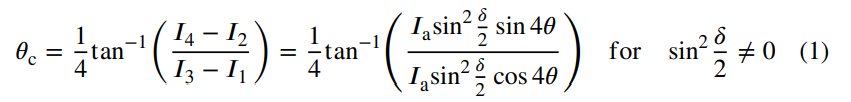

In [78]:
def generate_isoclinic_param(
        img_1: np.ndarray, 
        img_2: np.ndarray, 
        img_3: np.ndarray, 
        img_4: np.ndarray
) -> np.ndarray:
    """
    Images should be in order defined by Ramesh et al. 
    Returns the isoclinic parameter
    """
    return 1/4 * np.arctan2((img_4 - img_2),(img_3 - img_1))

In [79]:
isoclinic_param = generate_isoclinic_param(imgs[0], imgs[1], imgs[2], imgs[3])

In [80]:
isoclinic_param_2 = np.nan_to_num(generate_isoclinic_param(imgs_4_step[0], imgs_4_step[1], imgs_4_step[2], imgs_4_step[3]))

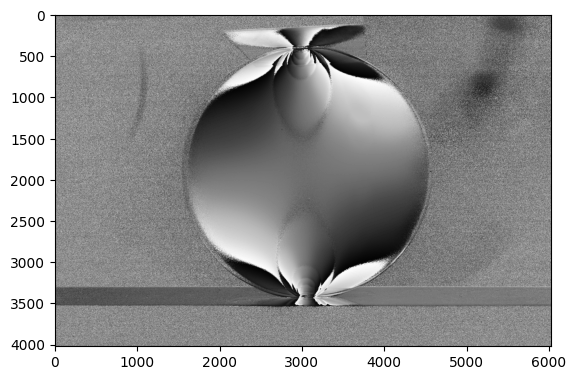

In [81]:
plt.imshow(isoclinic_param, cmap='gray')

In [82]:
plt.imsave('isoclinic.jpg', isoclinic_param_2, cmap='gray')   

### Generate isochromatic parameter
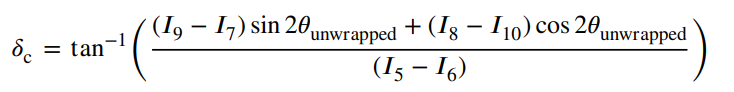


In [70]:
def generate_isochromatic_param(
    img_5: np.ndarray,
    img_6: np.ndarray,
    img_7: np.ndarray,
    img_8: np.ndarray,
    img_9: np.ndarray,
    img_10: np.ndarray,
    isoclinic_param: np.ndarray
) -> np.ndarray:
    return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) + 
                      (img_8 - img_10)*np.cos(2*isoclinic_param))/(img_5 - img_6))

In [71]:
isochromatic_param = generate_isochromatic_param(
    imgs[4],
    imgs[5],
    imgs[6],
    imgs[7],
    imgs[8],
    imgs[9],
    isoclinic_param
)

C:\Users\fredd\AppData\Local\Temp\ipykernel_18180\3016659149.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +
C:\Users\fredd\AppData\Local\Temp\ipykernel_18180\3016659149.py:10: RuntimeWarning: invalid value encountered in divide
  return np.arctan(((img_9 - img_7)*np.sin(2*isoclinic_param) +


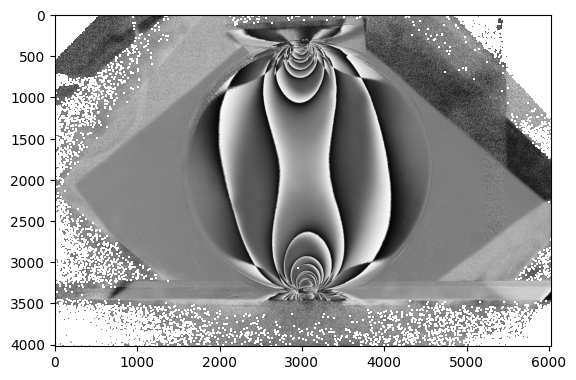

In [72]:
plt.imshow(isochromatic_param, cmap='gray')

In [73]:
plt.imsave('isochromatic.jpg', np.nan_to_num(isochromatic_param), cmap='gray')